# **MC-321 ML :** ASSIGNMENT 9
### **DHARMESH KOTA**
**202203038**

**Importing the necessary libraries**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.cluster import KMeans
import cvxpy as cp

# Question 1

Learn a SVM classifier on **iris** dataset. You can perform one-vs-all multiclass classification.


## • Hard-margin

- Using **CVXPY**, learn a hard-margin SVM classifier on the **dual problem**.  
- Normalize the data and then perform the same experiment on **normalized data**.  
- Plot the **decision boundary** (separating hyperplane) in **dark black** and the **margins** in **dotted lines**.  
  Encircle the **support vector** points.


## • Soft-margin

- Using **CVXPY**, learn a soft-margin SVM classifier on the **dual problem**.  
- Normalize the data and then perform the same experiment on **normalized data**.  
- Plot the **decision boundary** (separating hyperplane) in **dark black** and the **margins** in **dotted lines**.  
  Encircle the **support vector** points.


## • sklearn

- Use **sklearn** SVM classifier and perform classification on dataset.  
- Normalize the data and then perform the same experiment on **normalized data**.  
- Plot the **decision boundary** in **dark black** and the **margins** in **dotted lines**.  
  This time use **sklearn’s SVM** with a **linear kernel**.  
  Encircle the **support vector** points.  
  Do you get the same answer as when you use your own SVM?


Compare your results in **all three cases**.


In [ ]:
iris = datasets.load_iris()
X_raw = iris.data
y_raw = iris.target
class_labels = np.unique(y_raw)
target_names = iris.target_names
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_raw)

## **HARD MARGIN**

In [ ]:
def train_hard_margin_svm(X, y):
    n = X.shape[0]
    K = X @ X.T
    Q = np.outer(y, y) * K

    Q += 1e-6 * np.eye(n)

    alpha = cp.Variable(n)
    objective = cp.Maximize(cp.sum(alpha) - 0.5 * cp.quad_form(alpha, Q))
    constraints = [alpha >= 0, cp.sum(cp.multiply(alpha, y)) == 0]
    prob = cp.Problem(objective, constraints)
    prob.solve(solver=cp.SCS)


    if alpha.value is None:
        print("Solver failed! Returning zeros.")
        return np.zeros(X.shape[1]), 0, np.array([False]*n), np.zeros(n)

    alpha_val = alpha.value
    support_vector_indices = alpha_val > 1e-5
    w = (alpha_val * y) @ X
    b = np.mean(y[support_vector_indices] - X[support_vector_indices] @ w)

    return w, b, support_vector_indices, alpha_val

Running on raw PCA-reduced data...
Training classifier for class 0 vs all...


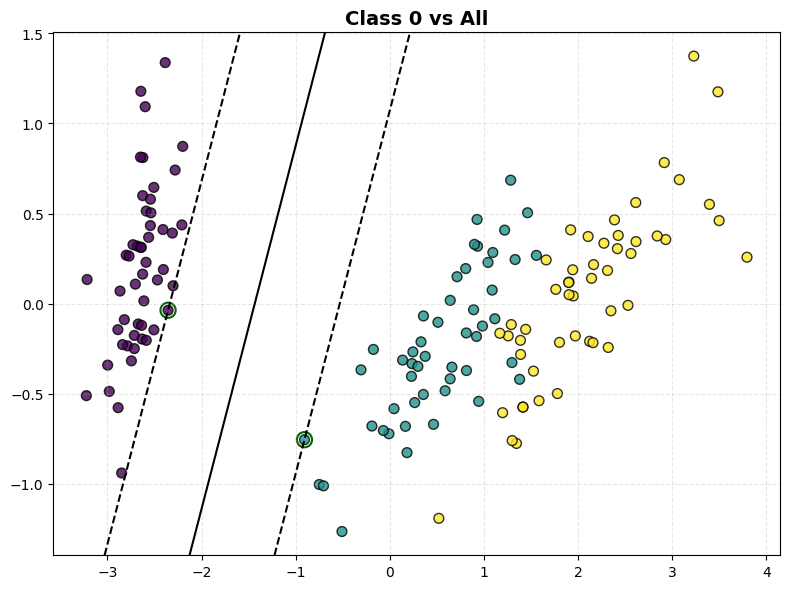

Training classifier for class 1 vs all...
Solver failed! Returning zeros.


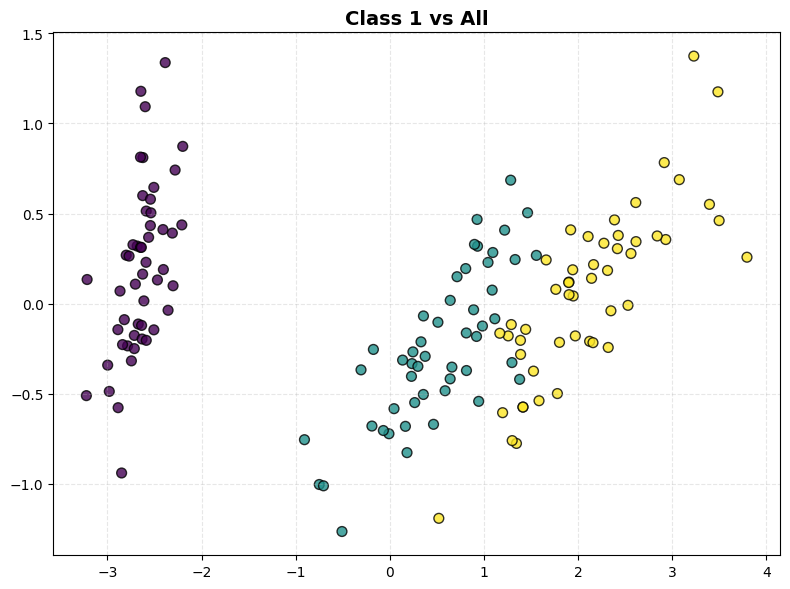

Training classifier for class 2 vs all...


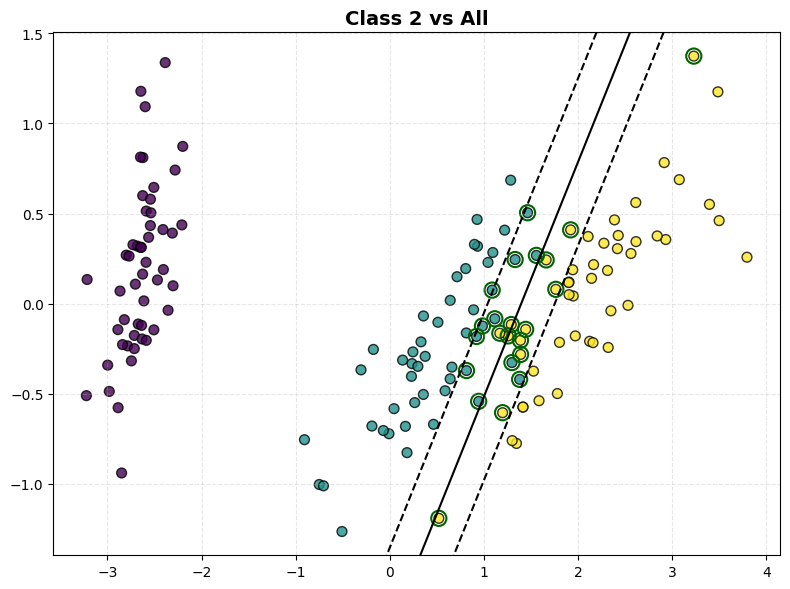

Running on normalized PCA-reduced data...
Training classifier for class 0 vs all...


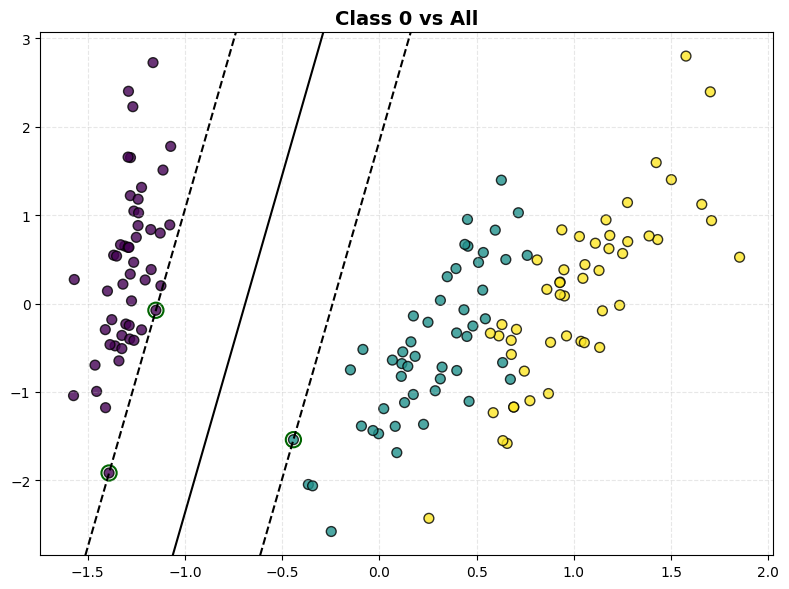

Training classifier for class 1 vs all...
Solver failed! Returning zeros.


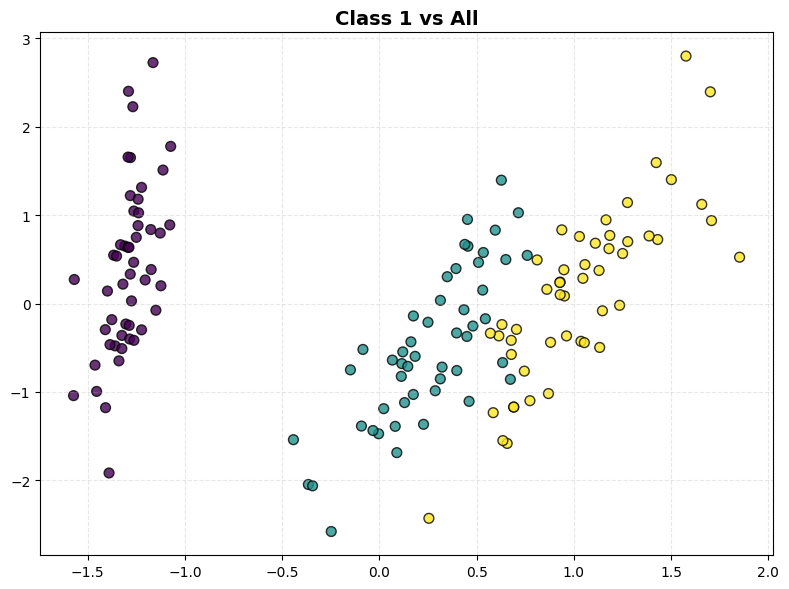

Training classifier for class 2 vs all...


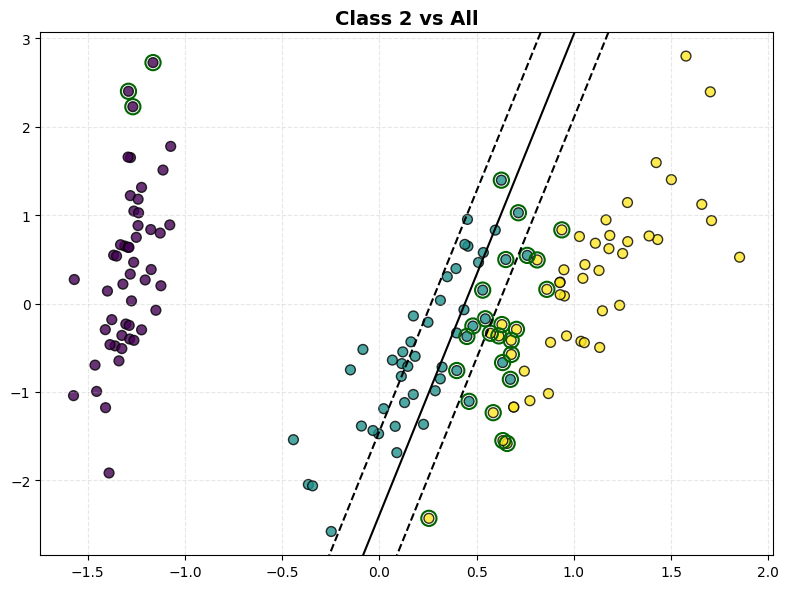

In [ ]:
def one_vs_all(X, y_all, class_labels):
    for cls in class_labels:
        y = np.where(y_all == cls, 1, -1)
        print(f"Training classifier for class {cls} vs all...")
        w, b, sv, alpha_val = train_hard_margin_svm(X, y)

        plt.figure(figsize=(8, 6))
        plt.scatter(
            X[:, 0], X[:, 1], c=y_all, cmap='viridis', edgecolors='black', s=50, alpha=0.8
        )

        ax = plt.gca()
        xlim = ax.get_xlim()
        ylim = ax.get_ylim()
        xx, yy = np.meshgrid(np.linspace(*xlim, 200), np.linspace(*ylim, 200))
        xy = np.vstack([xx.ravel(), yy.ravel()]).T
        Z = xy @ w + b
        Z = Z.reshape(xx.shape)

        plt.contour(
            xx, yy, Z, colors=['black'], levels=[-1, 0, 1],
            linestyles=['dashed', 'solid', 'dashed'], linewidths=1.5
        )

        plt.scatter(
            X[sv, 0], X[sv, 1], s=120, linewidth=1.5,
            facecolors='none', edgecolors='darkgreen', label='Support Vectors'
        )

        plt.title(f"Class {cls} vs All", fontsize=14, fontweight='bold')
        plt.grid(True, linestyle='--', alpha=0.3)
        plt.tight_layout()
        plt.show()

print("Running on raw PCA-reduced data...")
one_vs_all(X_pca, y_raw, np.unique(y_raw))

scaler = StandardScaler()
X_pca_norm = scaler.fit_transform(X_pca)
print("Running on normalized PCA-reduced data...")
one_vs_all(X_pca_norm, y_raw, np.unique(y_raw))

## **SOFT MARGIN**

In [ ]:
def train_soft_margin_svm(X, y, C=1.0):
    n = X.shape[0]
    K = X @ X.T
    Q = np.outer(y, y) * K + 1e-6 * np.eye(n)

    alpha = cp.Variable(n)
    objective = cp.Maximize(cp.sum(alpha) - 0.5 * cp.quad_form(alpha, Q))
    constraints = [alpha >= 0, alpha <= C, cp.sum(cp.multiply(alpha, y)) == 0]
    prob = cp.Problem(objective, constraints)

    try:
        prob.solve(solver=cp.ECOS)
    except cp.SolverError:
        prob.solve(solver=cp.SCS)

    if alpha.value is None:
        raise ValueError("Solver failed!")

    alpha_val = alpha.value
    support_vector_indices = alpha_val > 1e-5
    w = (alpha_val * y) @ X
    b = np.mean(y[support_vector_indices] - X[support_vector_indices] @ w)

    return w, b, support_vector_indices, alpha_val

Running on raw PCA-reduced data...
Training classifier for class 0 vs all...


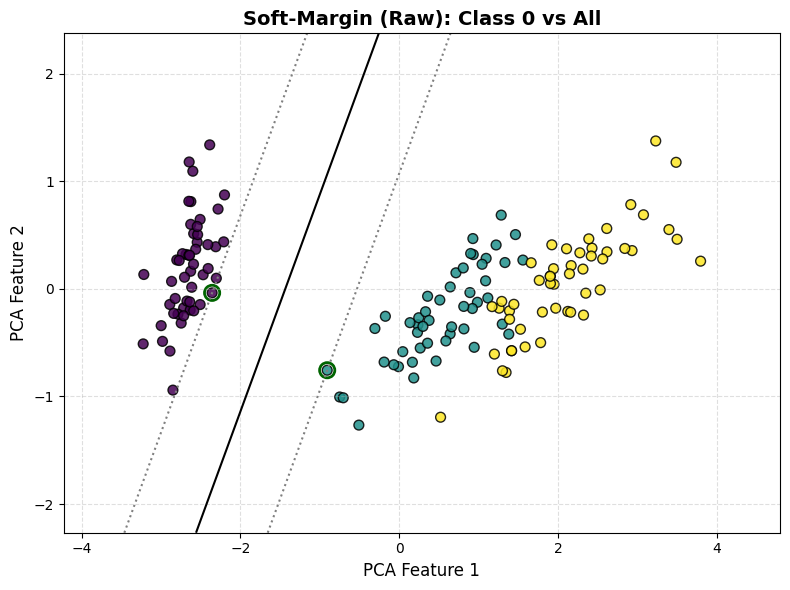

Training classifier for class 1 vs all...


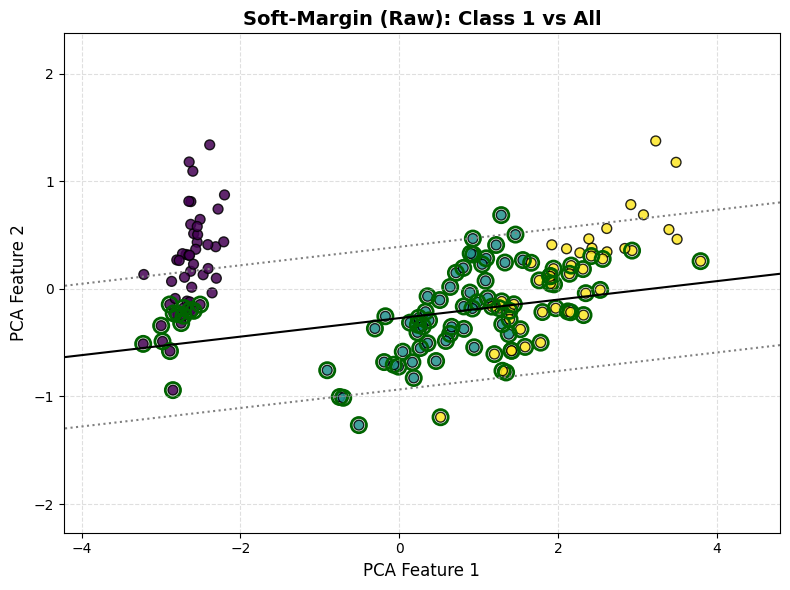

Training classifier for class 2 vs all...


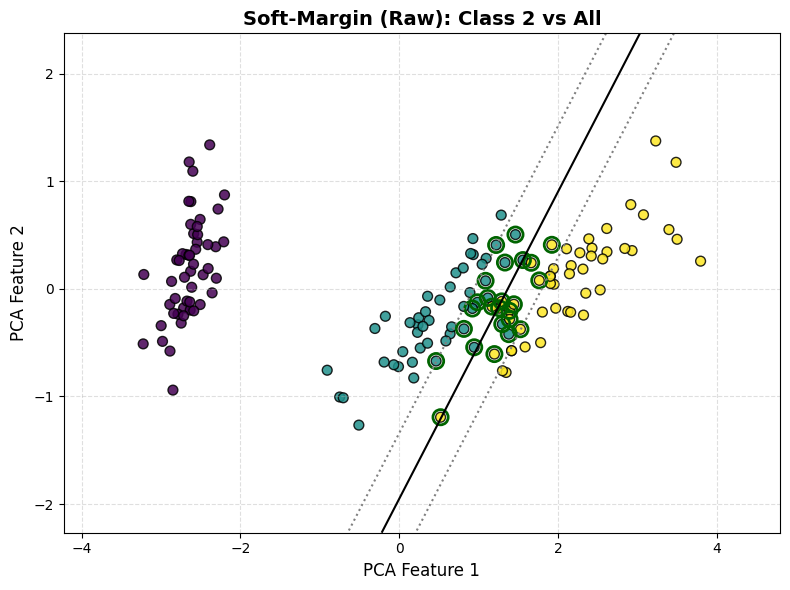

Running on normalized PCA-reduced data...
Training classifier for class 0 vs all...


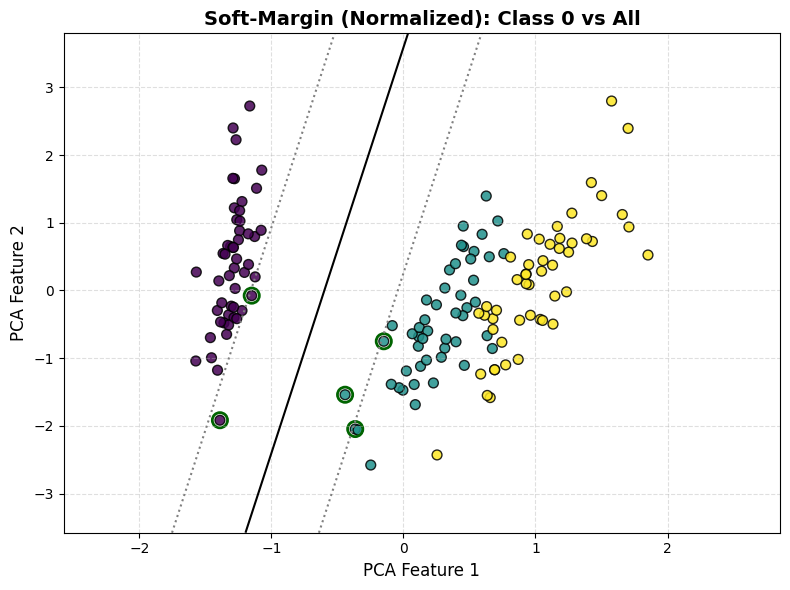

Training classifier for class 1 vs all...


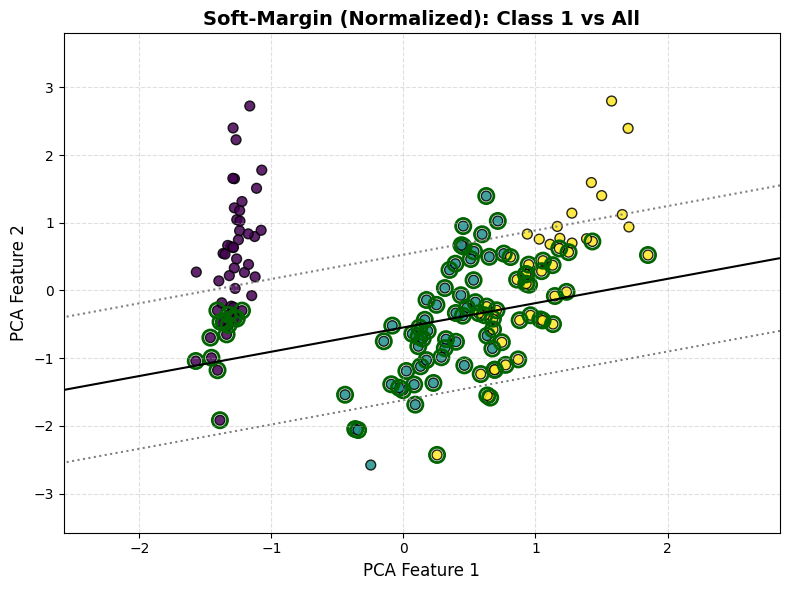

Training classifier for class 2 vs all...


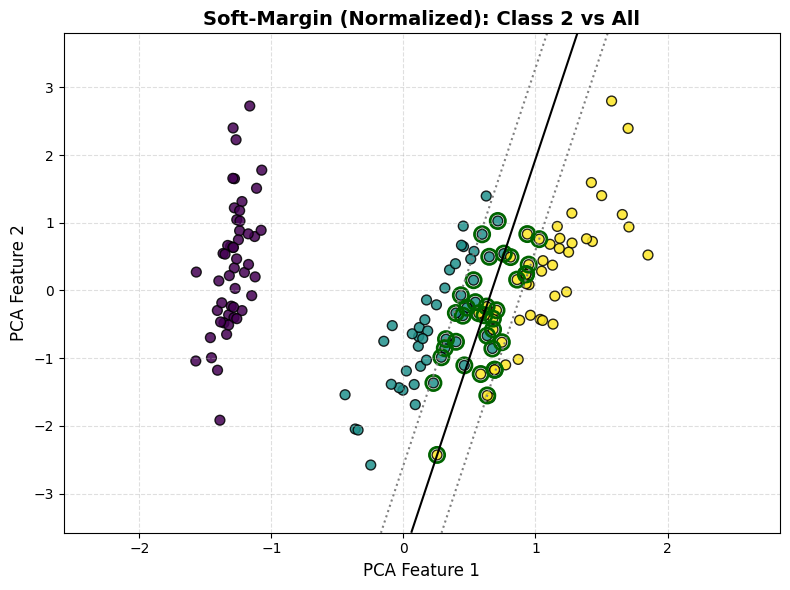

In [ ]:
def plot_svm(X, y_all, y, w, b, support_vector_indices, cls, title="Soft-Margin SVM"):
    plt.figure(figsize=(8, 6))

    x_min, x_max = X[:,0].min() - 1, X[:,0].max() + 1
    y_min, y_max = X[:,1].min() - 1, X[:,1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 500),
                         np.linspace(y_min, y_max, 500))
    Z = (w @ np.c_[xx.ravel(), yy.ravel()].T + b).reshape(xx.shape)

    plt.contour(
        xx, yy, Z, levels=[-1, 0, 1],
        colors=['gray', 'black', 'gray'],
        linestyles=['dotted', 'solid', 'dotted'],
        linewidths=1.5
    )

    plt.scatter(
        X[:, 0], X[:, 1], c=y_all, cmap='viridis',
        s=50, edgecolors='black', alpha=0.85
    )

    plt.scatter(
        X[support_vector_indices, 0], X[support_vector_indices, 1],
        s=120, facecolors='none', edgecolors='darkgreen', linewidths=2,
        label='Support Vectors'
    )

    plt.title(f"{title}: Class {cls} vs All", fontsize=14, fontweight='bold')
    plt.xlabel("PCA Feature 1", fontsize=12)
    plt.ylabel("PCA Feature 2", fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.4)
    plt.tight_layout()
    plt.show()

def one_vs_all_soft_margin(X, y_all, class_labels, C=1.0, title_prefix="Soft-Margin SVM"):
    for cls in class_labels:
        y = np.where(y_all == cls, 1, -1)
        print(f"Training classifier for class {cls} vs all...")
        w, b, sv, alpha_val = train_soft_margin_svm(X, y, C)
        plot_svm(X, y_all, y, w, b, sv, cls, title=title_prefix)

print("Running on raw PCA-reduced data...")
one_vs_all_soft_margin(X_pca, y_raw, class_labels, C=1.0, title_prefix="Soft-Margin (Raw)")

scaler = StandardScaler()
X_pca_norm = scaler.fit_transform(X_pca)
print("Running on normalized PCA-reduced data...")
one_vs_all_soft_margin(X_pca_norm, y_raw, class_labels, C=1.0, title_prefix="Soft-Margin (Normalized)")

## **sklearn**

In [ ]:
def plot_sklearn_svm(X, y, model, cls, title):
    plt.figure(figsize=(8, 6))

    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 500),
                         np.linspace(y_min, y_max, 500))
    Z = model.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contour(xx, yy, Z, levels=[-1, 0, 1], colors=['gray', 'black', 'gray'],
                linestyles=['dotted', 'solid', 'dotted'], linewidths=1.5)

    plt.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis', edgecolors='black', s=50, alpha=0.85)

    plt.scatter(model.support_vectors_[:, 0], model.support_vectors_[:, 1],
                s=120, facecolors='none', edgecolors='darkgreen', linewidths=2,
                label='Support Vectors')

    plt.title(title, fontsize=14, fontweight='bold')
    plt.xlabel("Feature 1", fontsize=12)
    plt.ylabel("Feature 2", fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.4)
    plt.tight_layout()
    plt.show()

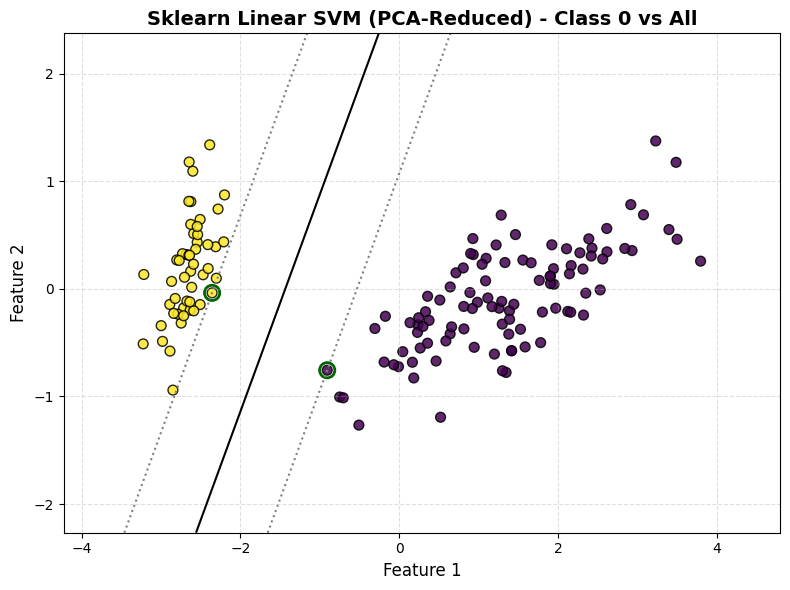

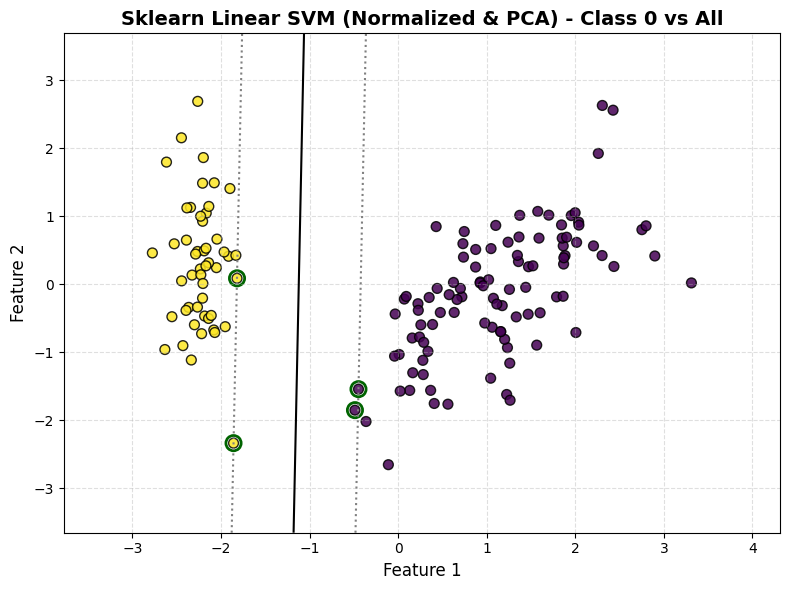

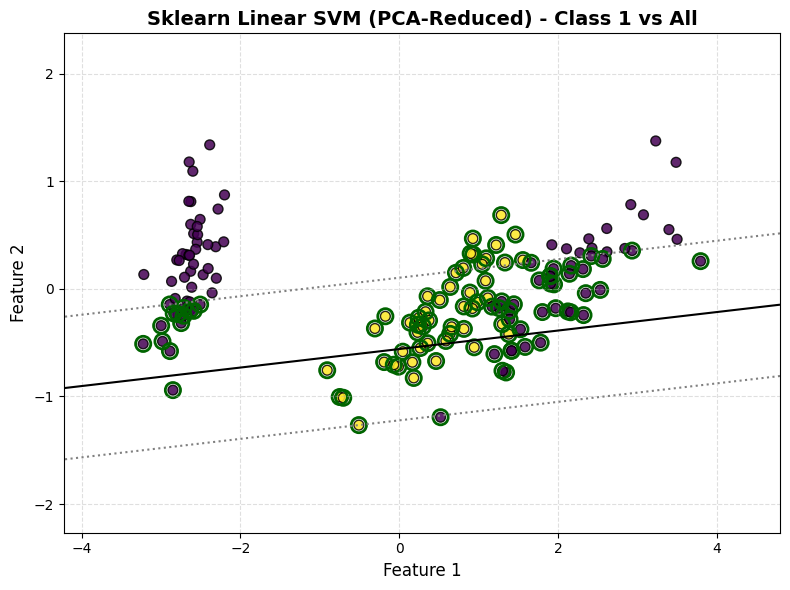

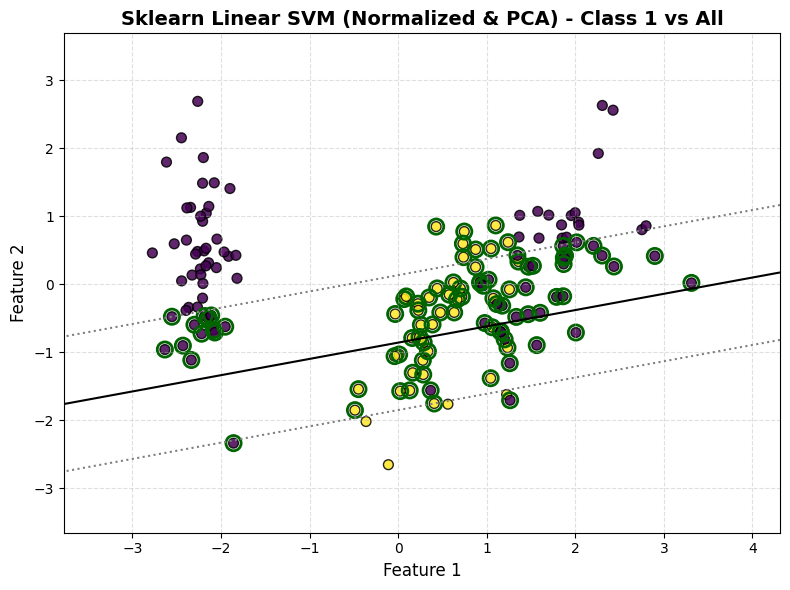

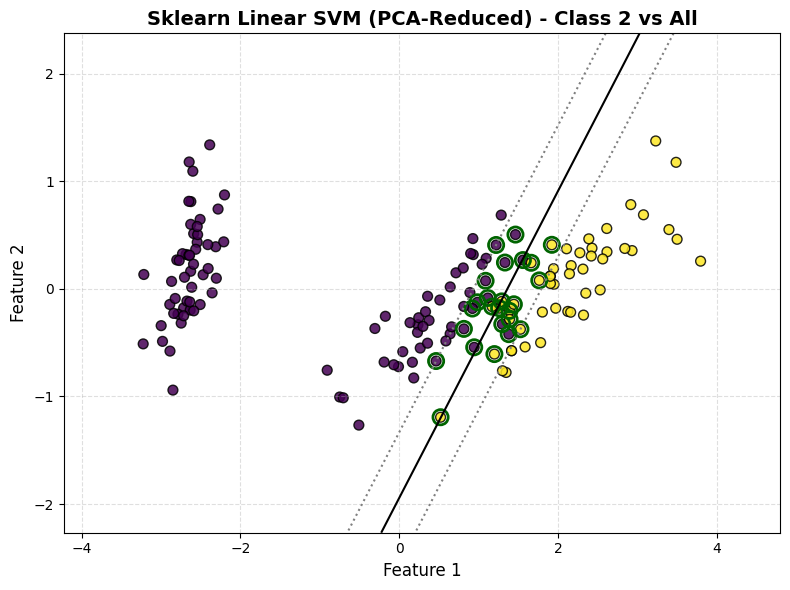

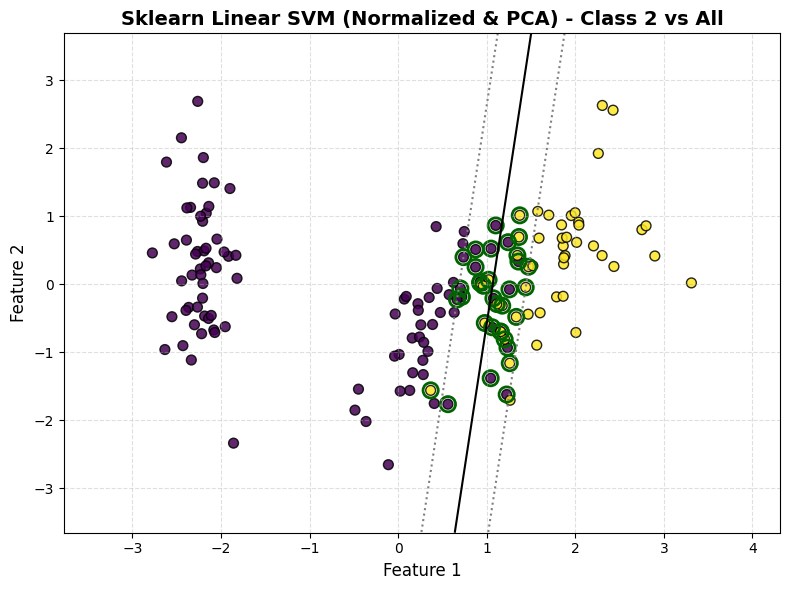

In [ ]:
for cls in np.unique(y_raw):
    y = np.where(y_raw == cls, 1, -1)

    X_pca = PCA(n_components=2).fit_transform(X_raw)
    clf_raw = SVC(C=1.0, kernel='linear')
    clf_raw.fit(X_pca, y)

    plot_sklearn_svm(X_pca, y, clf_raw, cls, f"Sklearn Linear SVM (PCA-Reduced) - Class {cls} vs All")

    scaler = StandardScaler()
    X_norm = scaler.fit_transform(X_raw)
    X_pca_norm = PCA(n_components=2).fit_transform(X_norm)

    clf_norm = SVC(C=1.0, kernel='linear')
    clf_norm.fit(X_pca_norm, y)

    plot_sklearn_svm(X_pca_norm, y, clf_norm, cls, f"Sklearn Linear SVM (Normalized & PCA) - Class {cls} vs All")

## **COMPARISION**

**Hard-margin vs Soft-margin:**

* A hard-margin classifier is highly sensitive to outliers, as it attempts to find the maximum margin without permitting any misclassifications. This rigidity can result in poor generalization if the data contains noise.

* On the other hand, a soft-margin classifier introduces flexibility by allowing some misclassifications. This enables it to achieve a wider margin while still accommodating errors, making it more robust to outliers.

**Support Vector Machines in Sklearn:**

* In Sklearn, the default SVM implementation applies a soft-margin strategy. The balance between the margin size and the permissible misclassifications is controlled by the parameter C.

* When you normalize the dataset, the results may change due to the impact of normalization on the individual feature scales, which can affect the model's decision boundary.

# Question 2

Implement **k-means clustering** algorithm. Use the two dataset (**Q2a** and **Q2b**) files for the  tasks below.


In [ ]:
df1 = pd.read_csv('https://docs.google.com/spreadsheets/d/1Cd71Rv_HEIfwSPtDQ79oaSpind8Fx7i7s47i4IhYeDs/export?format=csv')
df2 = pd.read_csv('https://docs.google.com/spreadsheets/d/1-aZGyoP1rLDhafG1Lntdoqe68WmAWqyjXkMDmQsw8y4/export?format=csv')

## a) Visualize the datasets  
- Plot the raw data points in 2D for both Q2a and Q2b.

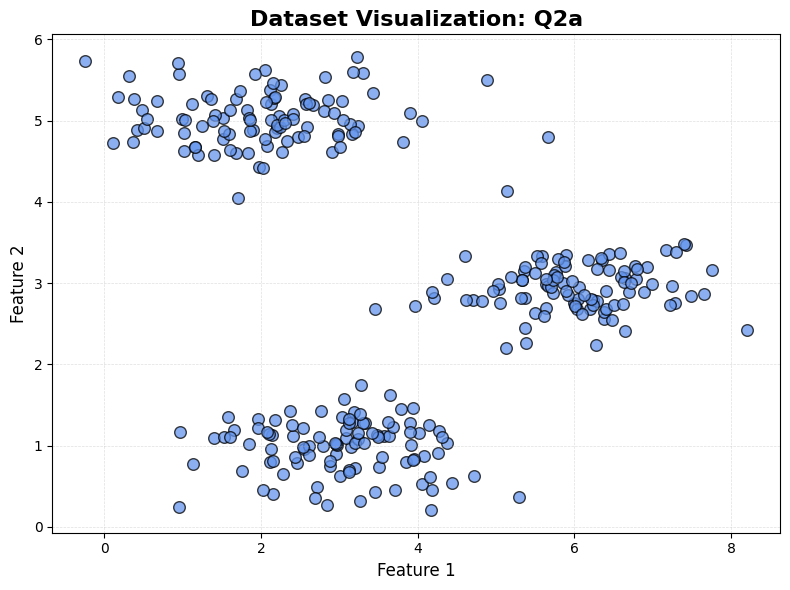

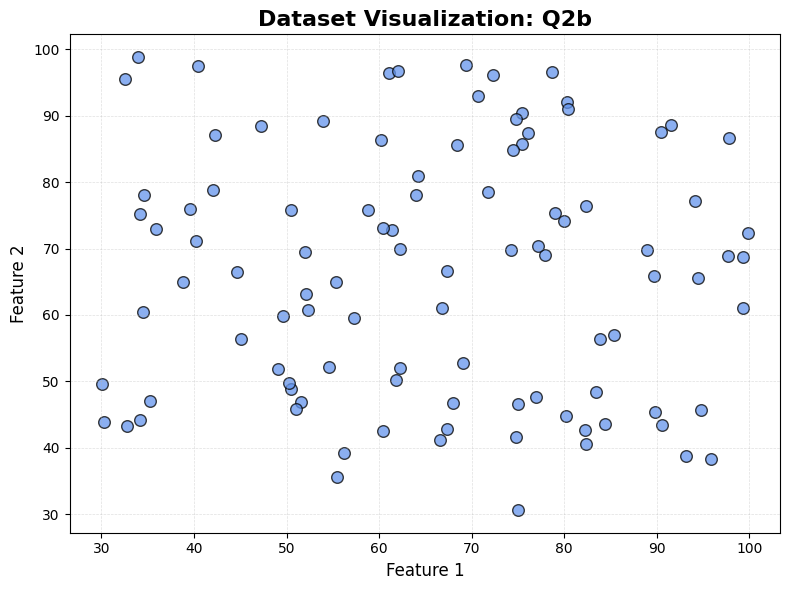

In [ ]:
def visualize_dataset(df, title):
    plt.figure(figsize=(8, 6))
    plt.scatter(
        df.iloc[:, 0], df.iloc[:, 1], c='cornflowerblue', s=70, edgecolors='black', alpha=0.75
    )
    plt.title(f'Dataset Visualization: {title}', fontsize=16, fontweight='bold')
    plt.xlabel('Feature 1', fontsize=12)
    plt.ylabel('Feature 2', fontsize=12)
    plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.4)
    plt.tight_layout()
    plt.show()

visualize_dataset(df1, 'Q2a')
visualize_dataset(df2, 'Q2b')

## b) Try different values of K  
- Use **random initial cluster centers**.  
- Run the algorithm for different values of $K$ (i.e. $K = 1, 2, 3, \dots$).

## c) Visualize cluster formation  
- For each value of $K$, plot the **clustered data** (with different colors) for both datasets.  
- Mark the **final cluster centers**.

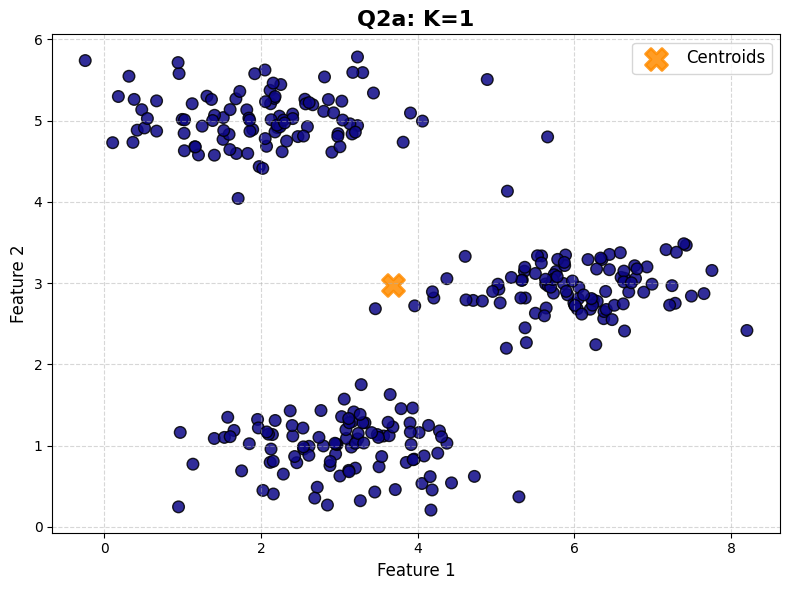

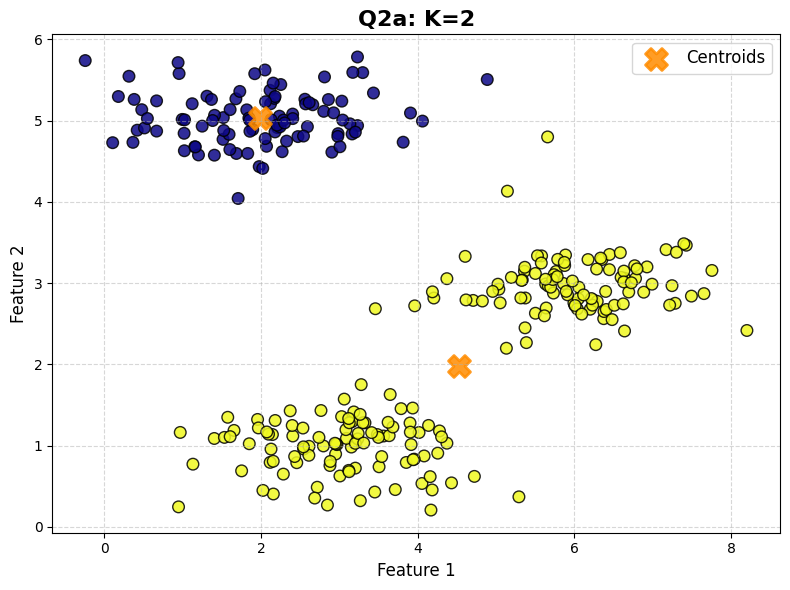

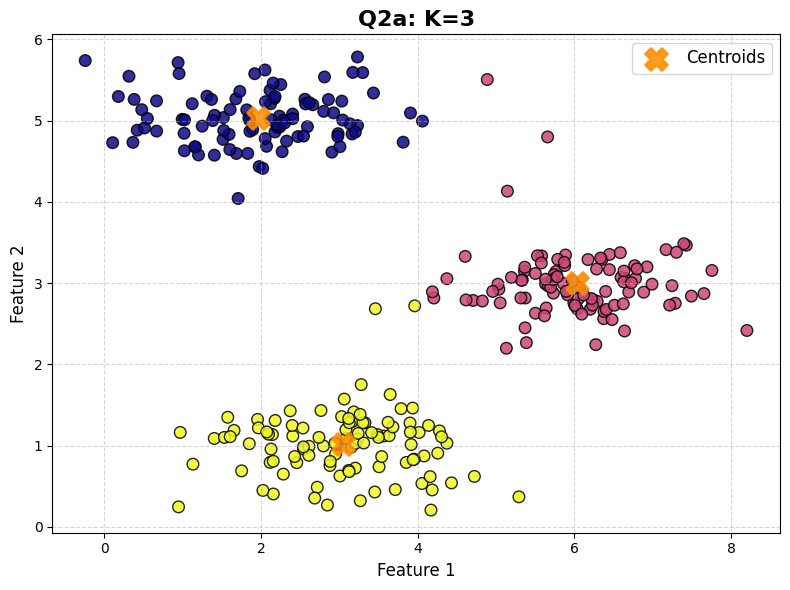

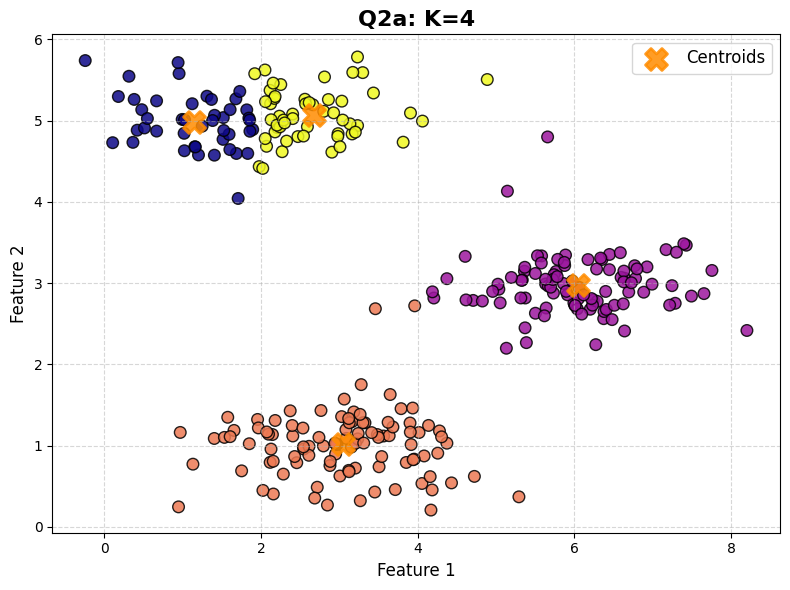

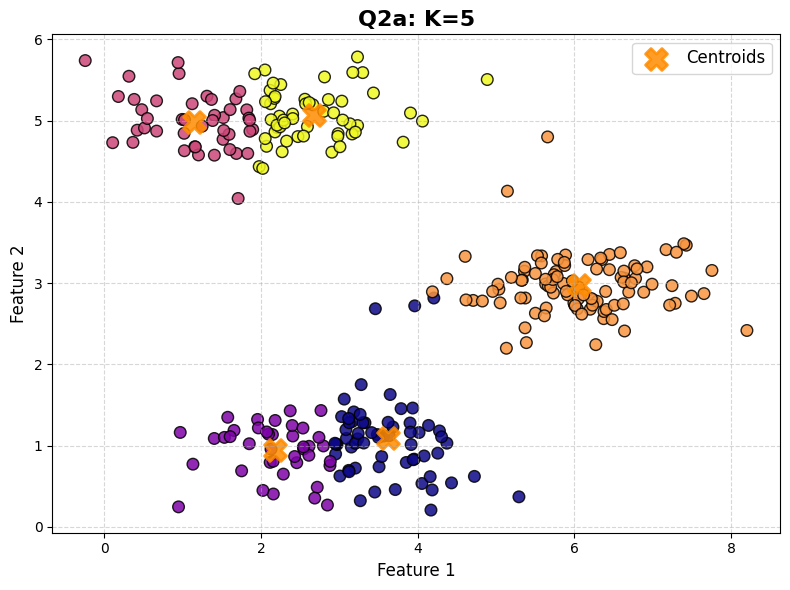

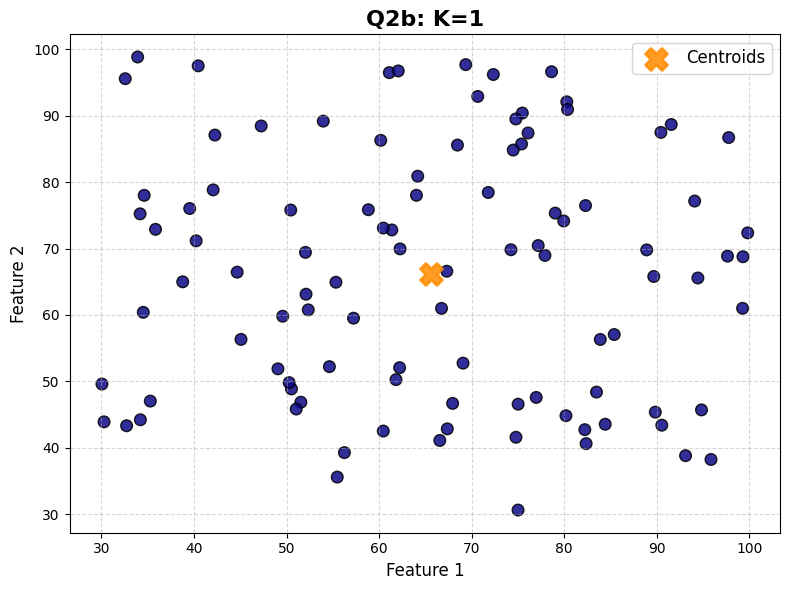

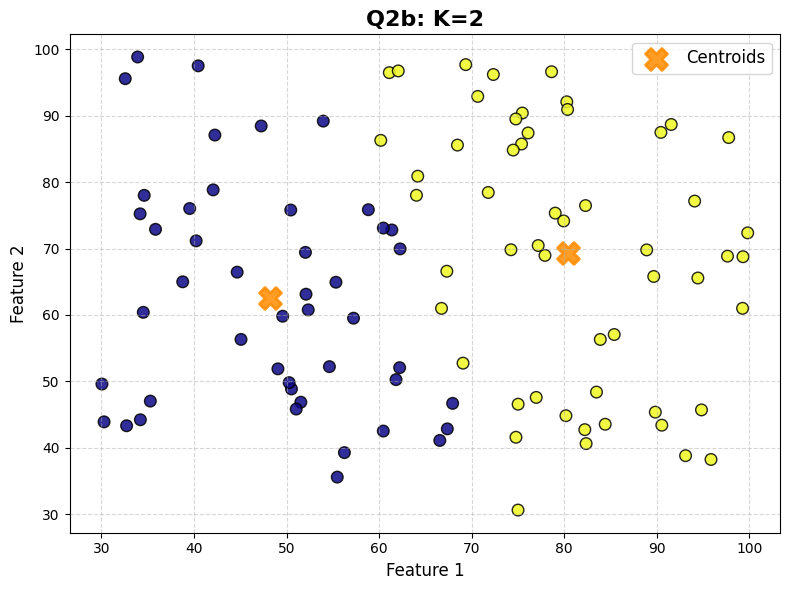

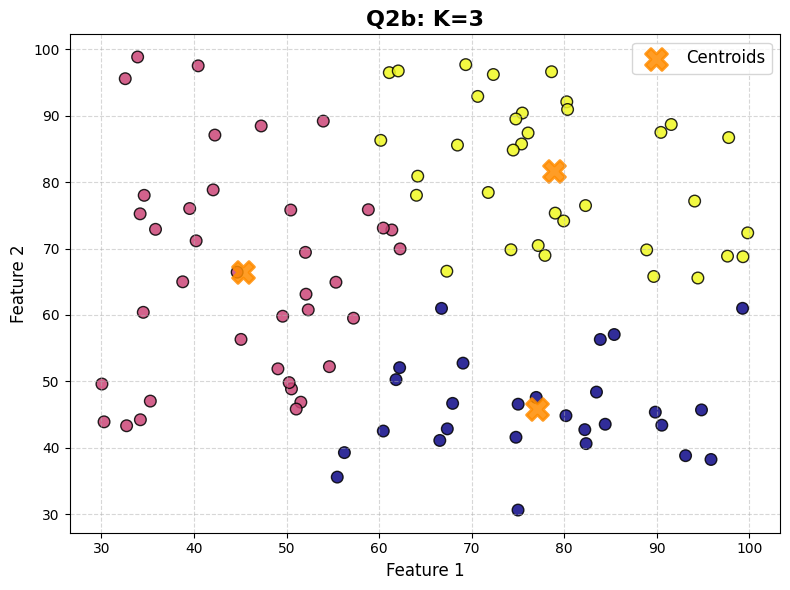

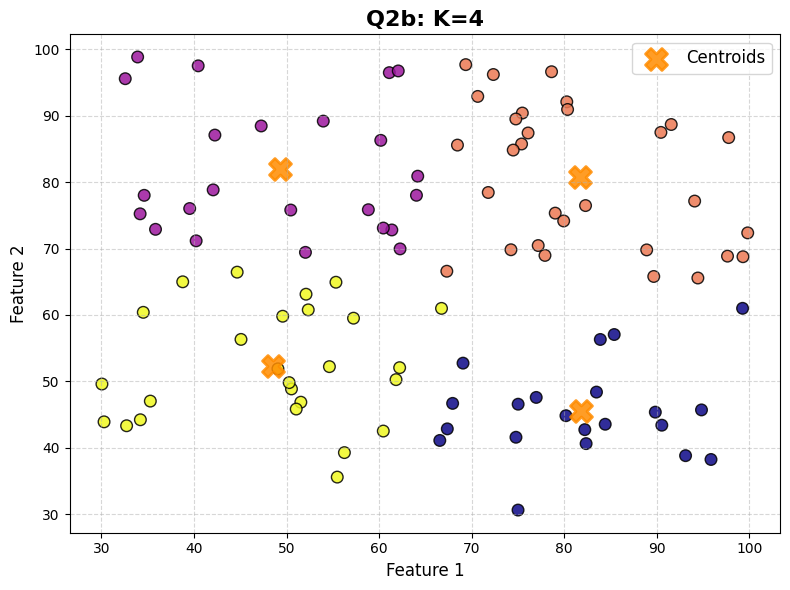

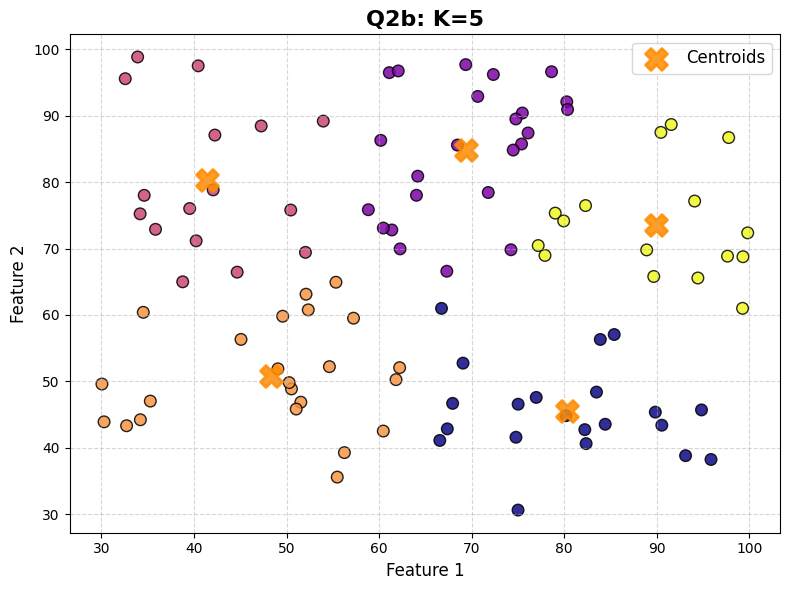

In [ ]:
def kmeans_clustering(df, dataset_name):
    X = df.values

    for k in range(1, 6):
        kmeans = KMeans(n_clusters=k, init='random', n_init=10, random_state=38)
        kmeans.fit(X)
        y_kmeans = kmeans.predict(X)

        plt.figure(figsize=(8, 6))
        plt.scatter(
            X[:, 0], X[:, 1], c=y_kmeans, s=70, cmap='plasma', alpha=0.85, edgecolors='black'
        )
        centers = kmeans.cluster_centers_
        plt.scatter(
            centers[:, 0], centers[:, 1], c='darkorange', s=250, alpha=0.85, marker='X', linewidths=2, label='Centroids'
        )
        plt.title(f'{dataset_name}: K={k}', fontsize=16, fontweight='bold')
        plt.xlabel('Feature 1', fontsize=12)
        plt.ylabel('Feature 2', fontsize=12)
        plt.legend(loc='best', fontsize=12)
        plt.grid(True, linestyle='--', alpha=0.5)
        plt.tight_layout()
        plt.show()


kmeans_clustering(df1, 'Q2a')
kmeans_clustering(df2, 'Q2b')

## d) Elbow Method  
- Compute the **within-cluster sum of squares (WCSS)** for each value of $K$.  
- Use the **Elbow Method** to determine the **optimal number of clusters $K$** for each dataset.

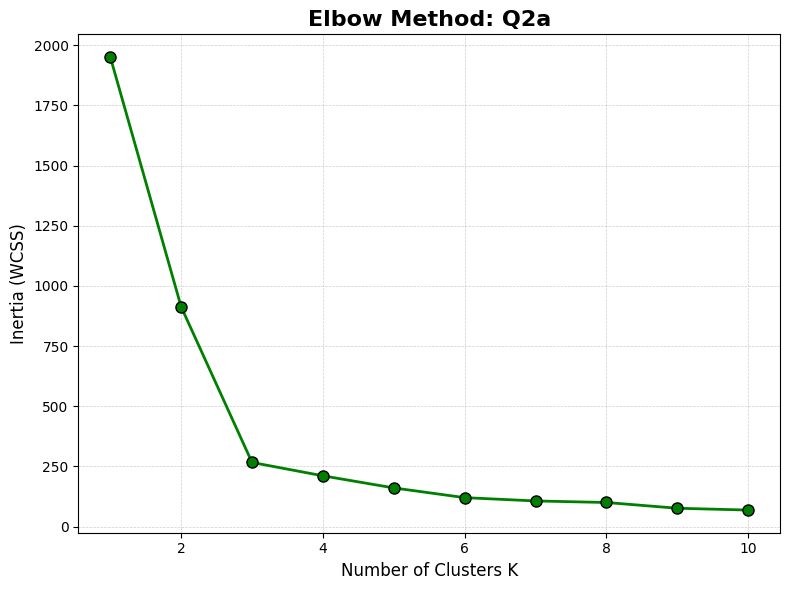

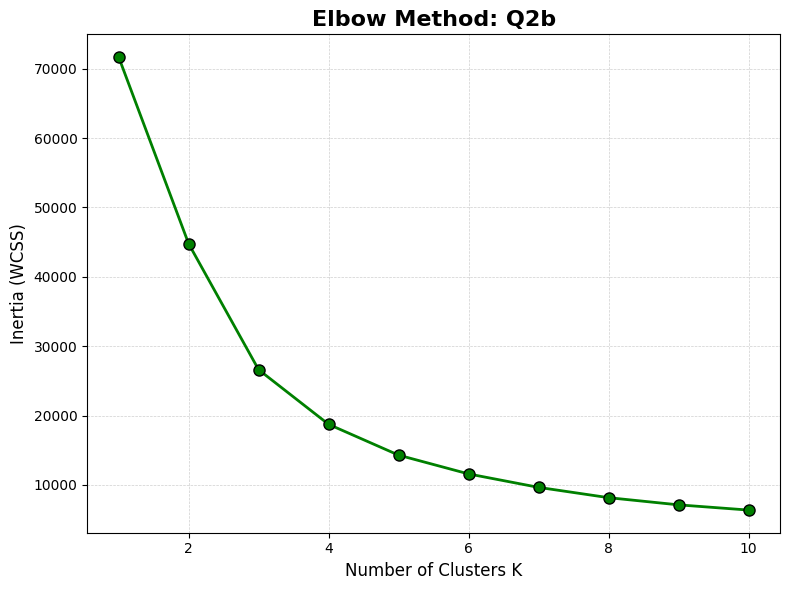

In [ ]:
def elbow_method(df, dataset_name):
    X = df.values
    distortions = []
    K_range = range(1, 11)

    for k in K_range:
        kmeans = KMeans(n_clusters=k, init='random', n_init=10, random_state=38)
        kmeans.fit(X)
        distortions.append(kmeans.inertia_)

    plt.figure(figsize=(8, 6))
    plt.plot(
        K_range, distortions, 'o-', color='green', markersize=8, linewidth=2, markeredgecolor='black'
    )
    plt.xlabel('Number of Clusters K', fontsize=12)
    plt.ylabel('Inertia (WCSS)', fontsize=12)
    plt.title(f'Elbow Method: {dataset_name}', fontsize=16, fontweight='bold')
    plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.6)
    plt.tight_layout()
    plt.show()

elbow_method(df1, 'Q2a')
elbow_method(df2, 'Q2b')

- The ideal value for **k** in the **Q2a** dataset is **3**.
- For the **Q2b** dataset, the optimal choice for **k** is **4**.